In [58]:
!pip3 install workalendar

In [59]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [60]:
import google.datalab.bigquery as bq

In [61]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker

In [62]:
import pandas as pd
import numpy as np

In [63]:
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta

In [64]:
from datetime import date
from workalendar.europe import Russia
cal = Russia()

Задача: спрогнозировать какое будет максимальное и среднее количество поисковых запросов за день в сумме со всех хостов будет в 2019м году.

В начале я опишу напишу последовательность действий, и далее буду более подробно останавливаться на интересных местах.
Вот главные этапы процесса предсказания:

    1. Визуализация данных
    2. Первичный выбор модели
    3. Генерация гипотез паттернов данных
    4. Построение первой модели
    5. Добавление фичей
    6. Тюнинг модели
    

In [65]:
%%bq query --name searches_query 
### query into dataset with raw data 
SELECT 
  s.date, 
  host, 
  searches,   
  IFNULL(c.change, 0) as change 
FROM `aviasales.aviasales.search1` s
  left join `aviasales.aviasales.currency1` c ON s.date = c.date
  where NOT (host = "web" and s.date = '2016-01-18') 
  and NOT (host = "Android" and s.date < '2016-02-16')
ORDER BY s.date, host

In [66]:
### getting data as DataFrame
df = searches_query.execute().result().to_dataframe() 
df['date'] = pd.to_datetime(df['date'])
df.shape

(3570, 4)

Нарисуем данные за весь период по всем платформам, для первичного анализа:

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


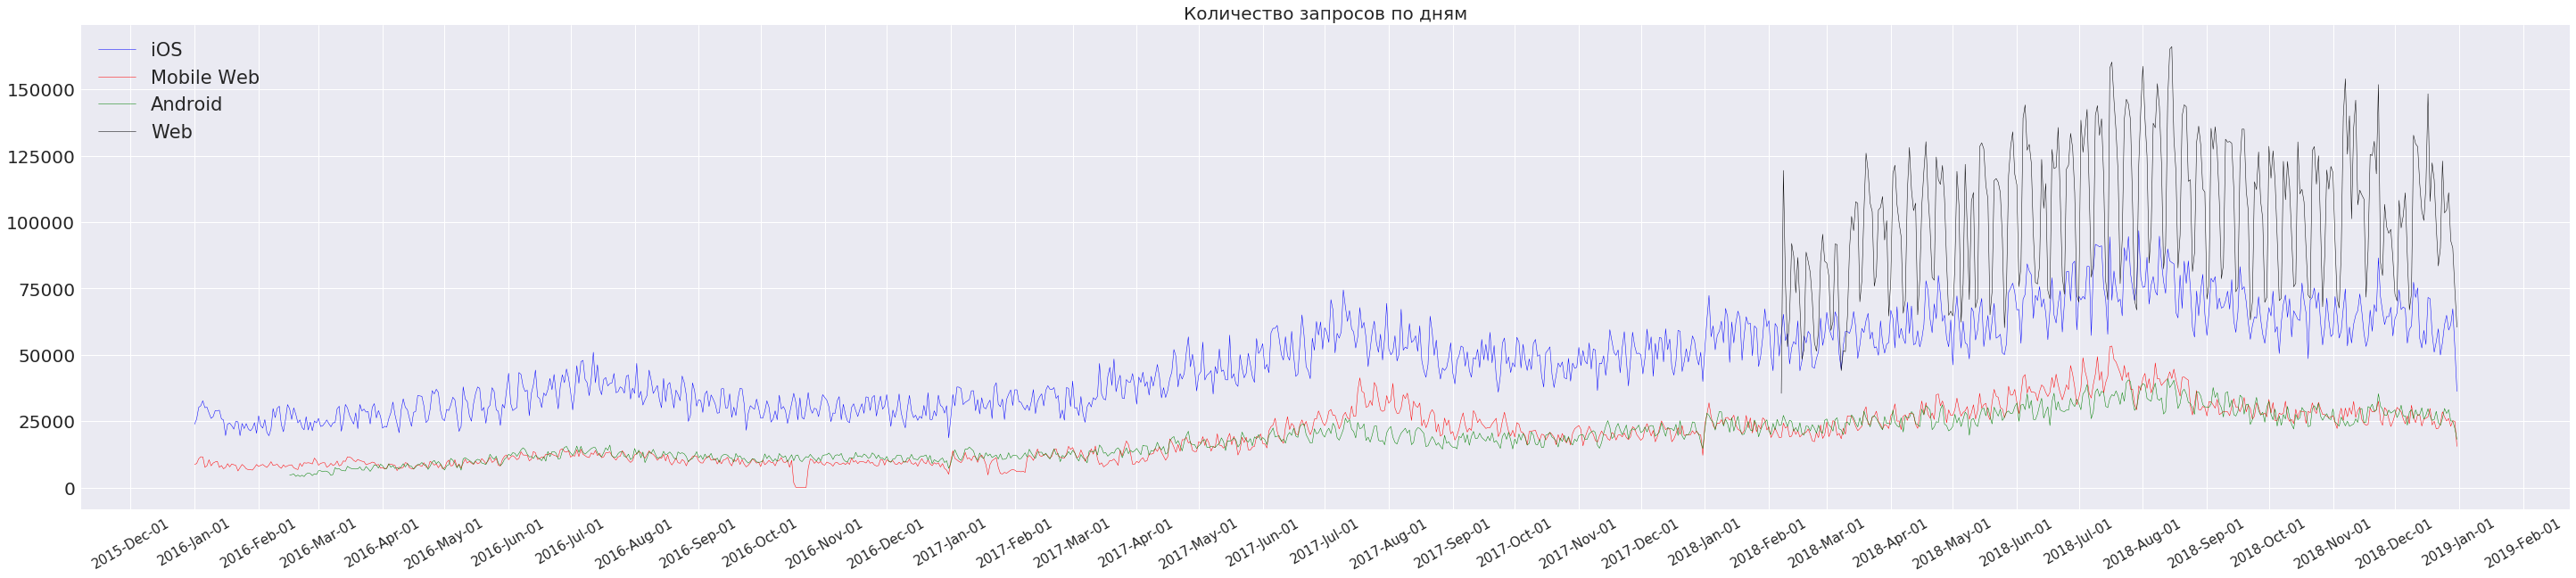

In [67]:
fig, ax = plt.subplots()

date_format = mdates.DateFormatter('%Y-%b-%d') 
months = mdates.MonthLocator() 
days_loc = mdates.DayLocator(bymonthday=(1))

mask_ios = df['host'] == 'iOS'
mask_mweb = df['host'] == 'mobile_web'
mask_android = df['host'] == 'Android'
mask_web = df['host'] == 'web'

plt.plot(df.loc[mask_ios, 'date'], df.loc[mask_ios, 'searches'], linewidth=0.5, c='blue', label='iOS')
plt.plot(df.loc[mask_mweb, 'date'], df.loc[mask_mweb, 'searches'], linewidth=0.5, c='red', label='Mobile Web')
plt.plot(df.loc[mask_android, 'date'], df.loc[mask_android, 'searches'], linewidth=0.5, c='green', label='Android')
plt.plot(df.loc[mask_web, 'date'], df.loc[mask_web, 'searches'], linewidth=0.5, c='black', label='Web')

plt.title("Количество запросов по дням", fontsize=20)
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(days_loc)
ax.xaxis.set_tick_params(rotation=30, labelsize=15)
ax.yaxis.set_tick_params(labelsize=20)
ax.legend(loc=2,prop={'size':21})

matplotlib.rc('figure', figsize=(50, 10))

plt.show()

Из графика всех запросов за все время и по всем платформам видно что:
- Для Web часть данных было потеряно
- Для Android данные начинаются не сразу, скорее всего был релиз продукта (начало февраля 2016 года)
- Есть годовая сезонность
- Есть недельная цикличность
- Разные платформы растут с разной скоростью. По web'у данных мало, но скорее web стагнирует. Возможно запросы из Web переходят в другие интерфейсы, как пример в мобильные телефоны

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


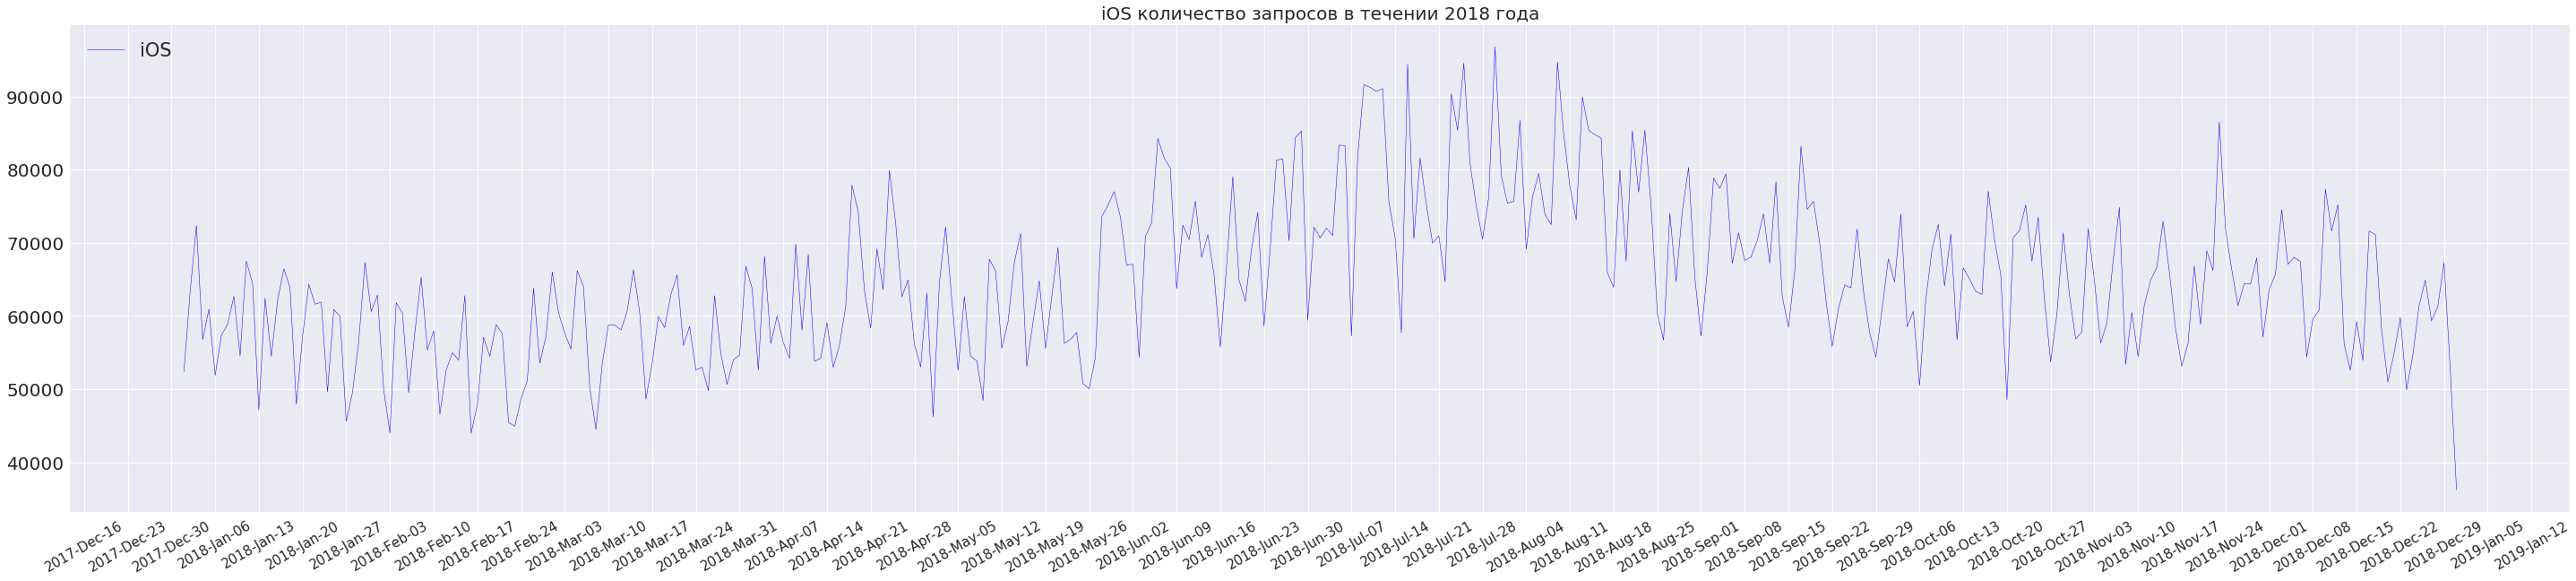

In [68]:
fig, ax = plt.subplots()

date_format = mdates.DateFormatter('%Y-%b-%d') 
months = mdates.MonthLocator() 
days_loc = mdates.WeekdayLocator(5)

mask_2018 = (df['date'].dt.year == 2018) & (mask_ios)
plt.plot(df[mask_2018]['date'], df['searches'][mask_2018], linewidth=0.5, c='blue', label='iOS')

plt.title("iOS количество запросов в течении 2018 года", fontsize=20)
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(days_loc)
ax.xaxis.set_tick_params(rotation=30, labelsize=15)
ax.xaxis.set_tick_params(rotation=30, labelsize=15)
ax.yaxis.set_tick_params(labelsize=20)
ax.legend(loc=2,prop={'size':21})

matplotlib.rc('figure', figsize=(50, 10))

plt.show()

Из графика iOS запросов за 2018 год видно что:
- Дельта в недельном цикле между пиком и минимум не изменяется сильно. Но есть выбросы
- Сезонные изменения по месяцам между платформами похожа

Задача стоит в экстраполяции данных. Можно изначально выбрать вариант с линейной регрессии. Я выбрал Lasso, так как в модель будет передаваться значительное количество параметров, часть которые не имеют большой значимости и возможно Lasso сможет обнулить эти параметры. Метрику оптимизации я выбрал Root Mean Square Error(RMSE). Так же изначально я хотел обучить одну модель на все четыре платформы, чтобы легче смоделировать тренд и повторяющие всплески запросов. Так же, не слабую роль в изменении количество запросов играет роль переход пользователей с одной платформы на другую. Мне кажется что будет легче смоделировать такие переходы в единой модели. Но позже, я решил обучить для каждой платформы свою модель, так как скорость роста каждой модели слишком сильно различается и это добавляет вариационности в модель.

Гипотезы о паттернах в данных:
- В выходные и праздики люди чаще делают запросы (улучшает модель)
- Перед большими выходными люди делают чаще покупки билетов (не влияет)
- Новый год - затишье (улучшает модель)
- Тренд стоит смотреть по неделям не по дням (реальзовано)
- День недели влияют на коичество запросов (улучшает модель)
- Месяцы очень сильно влияют на количество запросов (улучшает модель)
- День месяца может влиять на количетсов запросов (не влияет)
- Изменение валюты может влиять на количетво запросов (не влияет)
- Рекламные акции авиакомпаний сильновлияют на количество запросов (стоит проверить)
- Негатиные новости связанные с безопатностью влияет на количетсво запросов (стоит проверить)

In [69]:
%%bq query --name distinct_hosts_query
SELECT distinct host FROM `aviasales.aviasales.search1`

In [70]:
hosts = distinct_hosts_query.execute().result().to_dataframe()
hosts

,host
0,iOS
1,web
2,Android
3,mobile_web


In [71]:
df_2019 = pd.DataFrame()
for host in hosts.values:
  rng_2019 = pd.date_range('2019-01-01', periods=365, freq='D')
  df_temp = pd.DataFrame({ 'date': rng_2019, 'searches': 0, 'change': 0, 'host': host[0]})
  df_2019 = pd.concat([df_2019, df_temp], axis = 0)

df_ext = pd.concat([df, df_2019], axis = 0)
df_ext.sort_values(['date', 'host'], ascending=[True, True], inplace=True)

df_ext.shape, df.shape

((5030, 4), (3570, 4))

In [72]:
counter = 0
prev_week = 0

def incr_week(monthofyear):
  global counter, prev_week
  if prev_week == monthofyear:
    return counter
  else:
    counter += 1
    prev_week = monthofyear
    return counter

Далее код фичеринга - находжение дополнительных данных из имеющих данных или получение данных снаружи

In [73]:
### Addind new features into data
trend_attribs = ['month', 'dayofweek', 'weekofyear']

X_trend = pd.concat([pd.get_dummies(getattr(df_ext['date'].dt, i), prefix=i) for i in trend_attribs], axis = 1)
X_trend['weeksfromstart'] = df_ext['date'].dt.weekofyear.apply(incr_week)
X_trend = pd.concat([X_trend, pd.get_dummies(df_ext['host'], prefix='host')], axis = 1)
X_trend.columns

X_trend['is_working_day'] = df_ext['date'].apply(lambda x: int(cal.is_working_day(x)))
X_trend['is_ny'] = df_ext['date'].apply(lambda x: int(x.month == 12 and x.day==31))

#X_trend['holidays_ahead'] = df_ext['date'].apply(lambda x: np.log(cal.get_working_days_delta(x, x + timedelta(days = 30))))
#X_trend['currency_change'] = df_ext['change'] 

y = df_ext['searches']

Далее показаны парамерты Lasso, после тюнинга

In [74]:
trend_params = {'alpha':0.05, 'fit_intercept':True, 'max_iter':15000}

Тут я хочу рассказать про Day Forward-Chaining кросс-валидацию. Для того чтобы модель была робастная и не переучивалась на каких-то определенных периодах, я решил испольовать DFC кросс-валидацию.
Я взял за промежуток для обучения первые 2 года и 1 месяц для валидации. После того как я обучил модель, я сохраняю полученную ошибку и повторяю процесс но добавив один месяц в промежуток для обучения и сдвигаю период валидации на один месяц. Таким образом, мы считаем среднюю ошибку за все месяцы в течении всего 2018 года. В итоге я делаю предсказание на всех месяцах и могу посмотреть в какие промежутки нужно добавить фичеринг или изменить парамерты модели.

In [75]:
### Day Forward-Chaining CV

for host in hosts.values[0:]:
  errors = []
  rng = list(pd.date_range('2018-01-01', periods=12, freq='M'))
  
  for edge in rng:
    validation_edge = edge + relativedelta(months=1)
    test_edge = validation_edge + relativedelta(months=1)

    train_mask = (df_ext['date'] < validation_edge) & (df_ext['host'] == host[0])
    valid_mask = (df_ext['date'] >= validation_edge) & (df_ext['date'] < test_edge) & (df_ext['host'] == host[0])

    if sum(train_mask):
      X_train = X_trend[train_mask]
      y_train = y[train_mask]

      X_valid = X_trend[valid_mask]
      y_valid = y[valid_mask]

      model = Lasso(**trend_params)
      model.fit(X_train, y_train)
      score_valid = np.sqrt(mean_squared_error(y_valid, model.predict(X_valid)))
      errors.append(score_valid)
  print(host[0], np.mean(errors))
  print(errors)
 

iOS 17373.155780826193
[5990.605972782423, 6582.516227437014, 6894.920418465878, 6926.280107949144, 10030.824834436991, 10780.373071025815, 6263.304792030105, 5870.973351043386, 7089.648757786107, 7696.204251554757, 70734.73535447282, 63617.48223092986]


/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


web 26734.748493243533
[22043.72202314273, 12075.375134608312, 15964.738976864894, 24734.87214684201, 24613.81694662696, 16899.818714634053, 8176.156878061353, 8344.112338809618, 21508.84207438186, 15892.919747069014, 95732.5199251612, 54830.08701272039]
Android 7928.861303757473
[3157.297966723124, 2737.9424341059917, 2188.6902033208967, 2725.519275846183, 5093.535778251514, 6276.306305260801, 3548.772067883702, 2819.7187115406978, 3916.2881108362926, 3215.728712583392, 30620.44683155565, 28846.089247181437]
mobile_web 8950.051139002626
[3046.583032335815, 3913.345339572734, 4024.278231012745, 6051.289471358971, 7246.383947338478, 5419.895702995736, 3580.013243617958, 3204.582286045973, 3854.271449750851, 4616.646822155149, 32839.931823820305, 29603.39231802679]


Далее, я обучаю модель с лучшими фичами и параметрами, делаю предсказание и сохраняю предсказания в BigQuery. Там же будет сравнение на графике предсказание трафика на последние 3 месяца 2018 года и реальные данные и экстраполяция на 2019 год. 

For host: iOS VALIDATION RMSE: 7532.00084529167


/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


For host: web VALIDATION RMSE: 15044.447674038372
For host: Android VALIDATION RMSE: 3694.320819012003
For host: mobile_web VALIDATION RMSE: 4406.700694986382


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


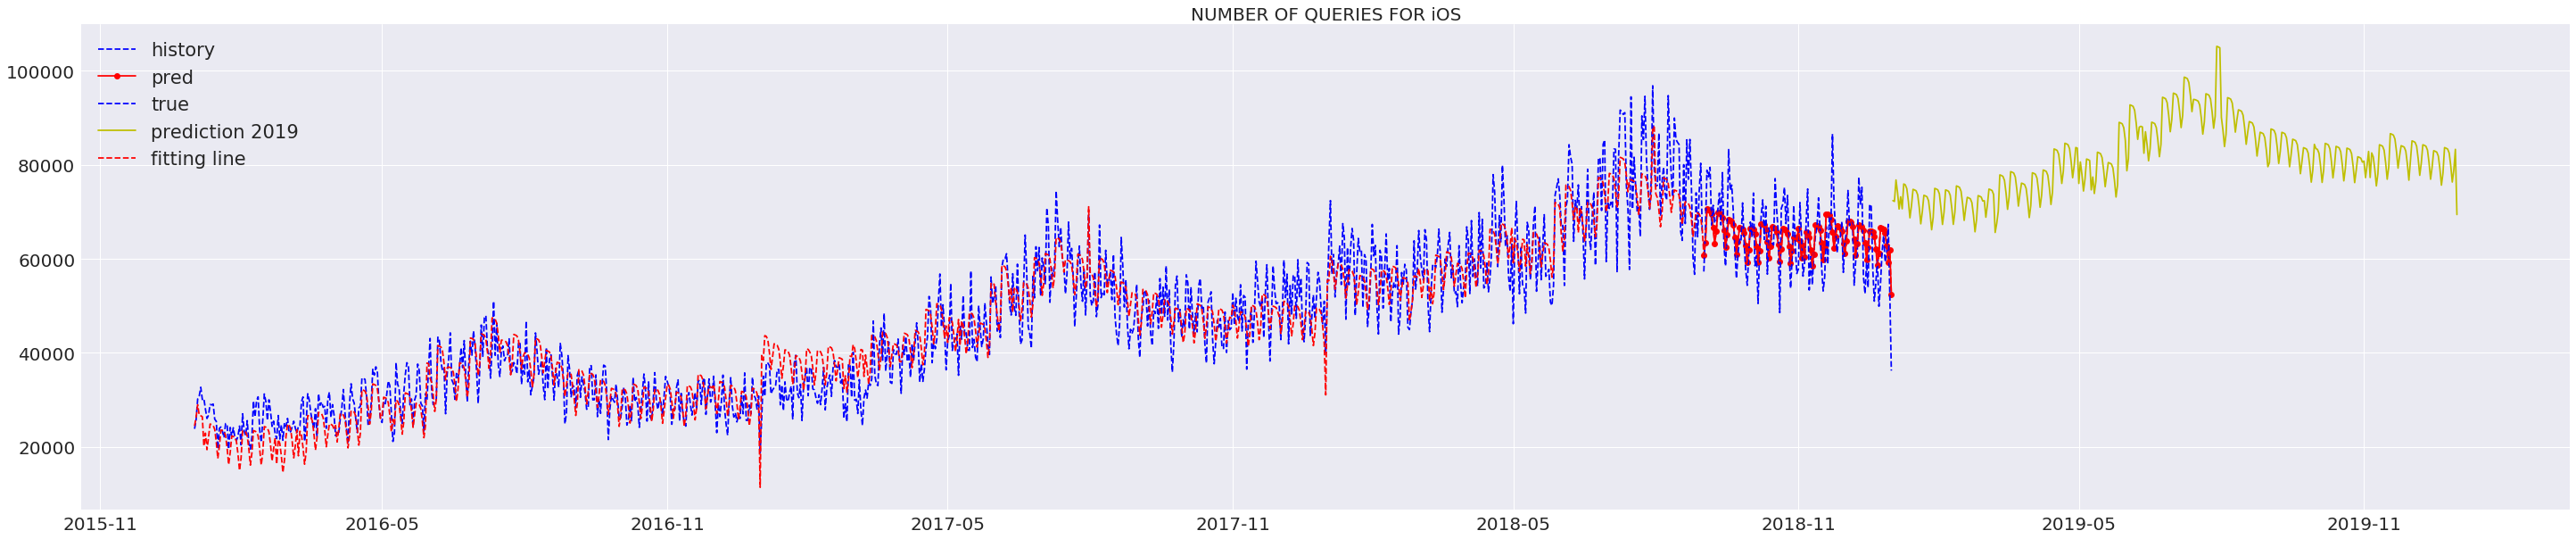

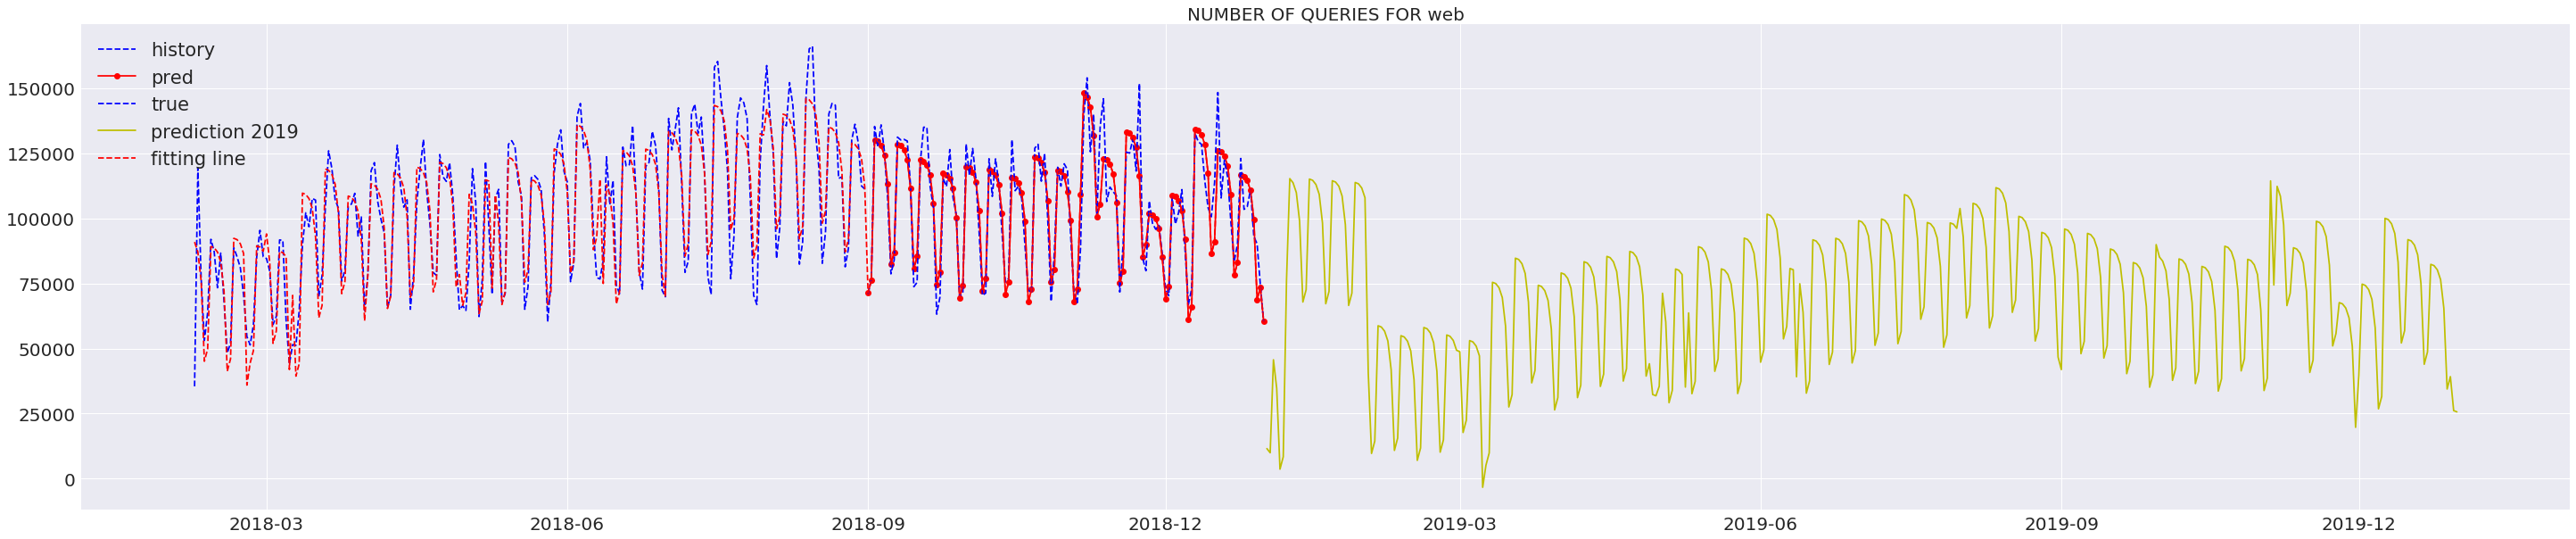

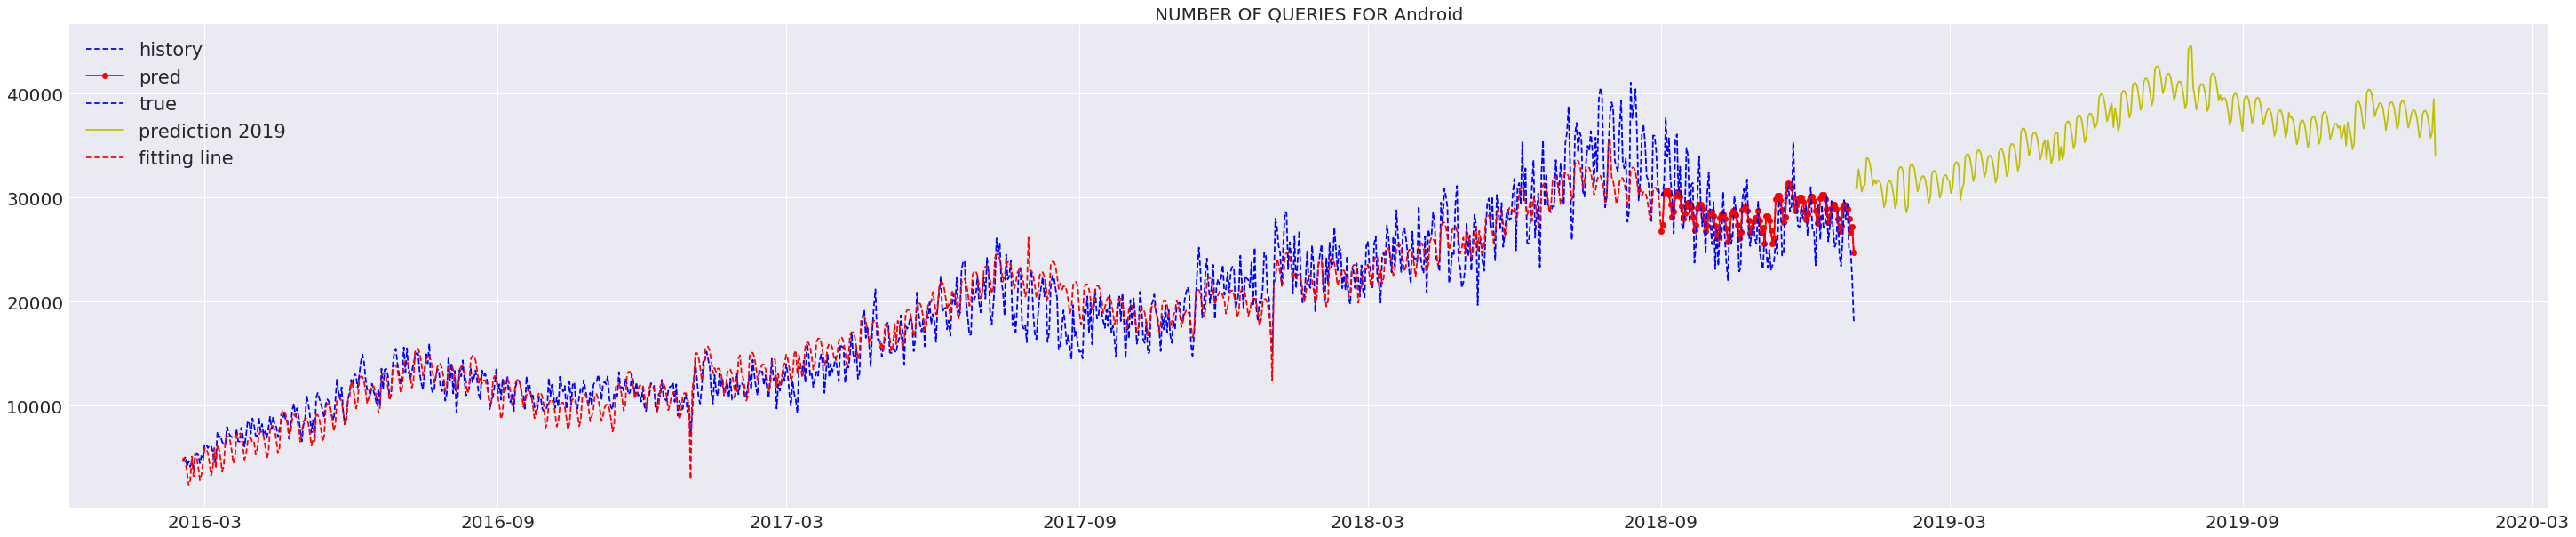

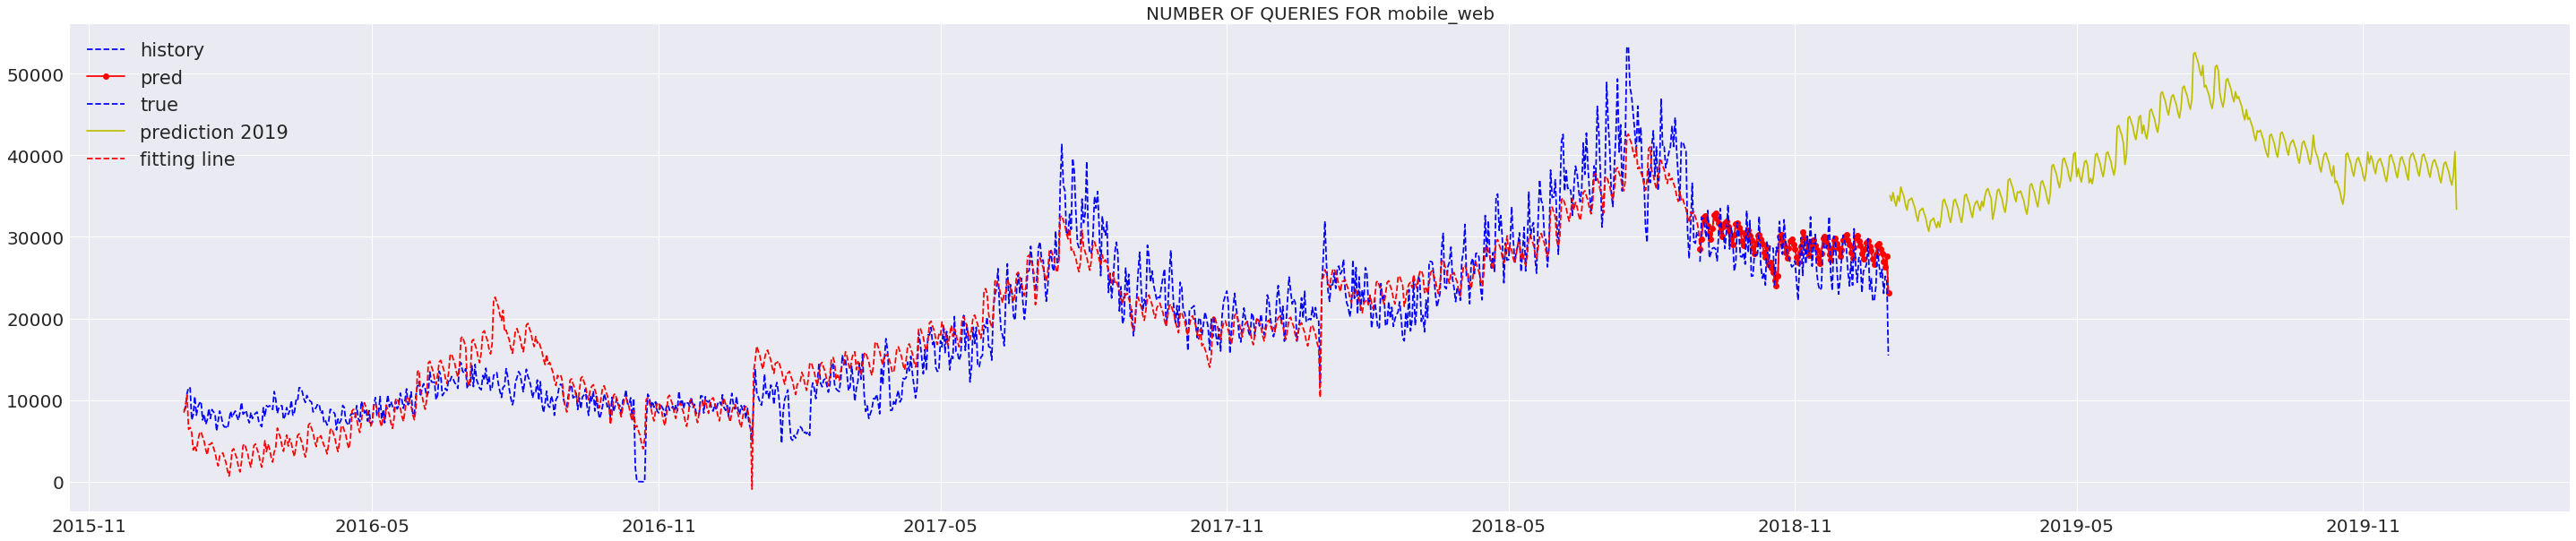

In [76]:
validation_edge = datetime(2018, 9, 1)
pred_edge = datetime(2019, 1, 1)


for host in hosts.values[0:]:
  
  train_mask = (df_ext['date'] < validation_edge) & (df_ext['host'] == host[0])
  valid_mask = (df_ext['date'] >= validation_edge) & (df_ext['date'] < pred_edge) & (df_ext['host'] == host[0])

  X_train = X_trend[train_mask]
  y_train = y[train_mask]

  X_valid = X_trend[valid_mask]
  y_valid = y[valid_mask]

  model = Lasso(**trend_params)
  model.fit(X_train, y_train)
  score_valid = np.sqrt(mean_squared_error(y_valid, model.predict(X_valid)))
  print('For host: {HOST} VALIDATION RMSE: {RMSE}'.format(HOST=host[0], RMSE=score_valid))
  
  
  all_data_mask = (df_ext['date'] < pred_edge) & (df_ext['host'] == host[0])
  pred_2019_mask = (df_ext['date'] >= pred_edge) & (df_ext['host'] == host[0])
  
  X_train_all = X_trend[all_data_mask]
  y_train_all = y[all_data_mask]
  model = Lasso(**trend_params)
  model.fit(X_train_all, y_train_all)
  all_data_predict = X_trend[pred_2019_mask]

  tdates = [i.date() for i in df_ext.loc[pred_2019_mask, 'date'].tolist()]
  temp_df = pd.DataFrame({'date': tdates, 'host': host[0], 'searches':model.predict(all_data_predict)})
  bq.Table('aviasales.aviasales_pred').insert(temp_df)  ## data insertion into BigQuery
  
  matplotlib.rc('figure', figsize=(50, 10))
  fig, ax = plt.subplots()
  plt.title("NUMBER OF QUERIES FOR {HOST}".format(HOST=host[0]), fontsize=20)
  plt.plot(df_ext.loc[train_mask, 'date'], y_train, 'b--', label = 'history')
  plt.plot(df_ext.loc[valid_mask, 'date'], model.predict(X_valid), 'ro-', label = 'pred')
  plt.plot(df_ext.loc[valid_mask, 'date'], y_valid, 'b--', label = 'true')
  plt.plot(df_ext.loc[pred_2019_mask, 'date'], model.predict(all_data_predict), 'y-', label = 'prediction 2019')
  plt.plot(df_ext.loc[all_data_mask, 'date'], model.predict(X_train_all), 'r--', label = 'fitting line')
  ax.xaxis.set_tick_params(labelsize=20)
  ax.yaxis.set_tick_params(labelsize=20)
  ax.legend(loc=2,prop={'size':21})
  


Здесь нарисованы графики для всех платформ
- Киний пунктир - настоящие данные
- Красный пунктир - то, как данные были смоделированные моделью
- Красная линия - предсказание, которое делает модель
- Желтая линия - предсказание на 2019 год

Предсказание на последних 3 месяцах довольно близко к реальным данным. Если посмотреть на метрики мы увидим что:
- Для iOS RMSE с среднем за 2018 год равняется 7532. Это примерно означает что предсказание будет ошибаться на 7500 запросов в плюс или минус. Это чуть более 10% от дневного количества запросов
- Для web RMSE с среднем за 2018 год равняется 15044 или около 15% от дневного количества запросов
- Для Android RMSE с среднем за 2018 год равняется 3694 или 12% от дневного количества запросов
- Для mobile_web RMSE с среднем за 2018 год равняется 4406 или 13% от дневного количества запросов

Для web слишком мало данных, нет данных даже за полный год. По-этому в первый квартал 2019 года предсказания совсем нерелевантные. Как вариант, можно было использовать тренды других платформ. Но с другой стороны, у меня нет уверенности что web продолжает расти или стагнирует. Я решил что я не буду доучивать модель для web данными с других платформ.

Запросы в BigQuery для того чтобы получить нужные данные

In [77]:
%%bq query --name max_queries
with grouped as (SELECT date, sum(searches) as searches_daily FROM `aviasales.aviasales.aviasales_pred` 
  group by date)
  
select date, searches_daily from grouped 
  order by searches_daily desc
  limit 1

In [78]:
%%bq query --name avg_queries
with grouped as (SELECT date, sum(searches) as searches_daily FROM `aviasales.aviasales.aviasales_pred` 
  group by date)
  
select avg(searches_daily) as searches_average from grouped 

Предсказанное максимальное количество запросов в день

In [79]:
mq = max_queries.execute().result()
mq

date,searches_daily
2019-07-29,298516.7502140265


Предсказанное среднее количество запросов в день

In [80]:
aq = avg_queries.execute().result()
aq

searches_average
226782.00104180627


Спасибо что дочитали до этой строки!